In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy as sc
from altair import *
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import OrderedDict
from ipywidgets import interact, interactive, fixed
from IPython.display import display
from sklearn.linear_model import Ridge
from feat import *

In [4]:
#thresh is a positive value float that determines the binning boundaries (-thresh, 0, and thresh)
def four_bins(thresh):
    def bin_function(val):
        if (val <= -thresh):
            return -2
        elif (val > -thresh and val < 0.0):
            return -1
        elif (val == 0.0):
            return 0
        elif (val > 0.0 and val < thresh):
            return 1
        elif (val >= thresh):
            return 2
    return bin_function

In [5]:
cldir = './data/CL/'
rutdir = './data/RUT/'
gldir = './data/GLD/'
src = cldir

data = pd.read_csv(src + '/1_merged/in_sampleFF.csv')
# data['year'] = data['Date'].str[:4].astype(int)
# data['Z_dailydir2'] = data['Z_dailypct'].map(four_bins(.015), na_action='ignore')

labelName = 'Z_dailydir'
label_list = ['Z_dailydir2', 'Z_dailydir']
pricestats=['Date', 'Z_dailypct']
sent_list = tuple(sorted([col for col in data.columns if ((col[0]=='N' or col[0]=='S') and 'buzz' not in col)]))
full_list = sent_list + ('Z_dailypct',)
data.head(5)

   Unnamed: 0        Date  N_buzz  N_conflict  N_consumptionVolume  \
0           0  2000-01-01   201.1    0.004973             0.004973   
1           1  2000-01-02   132.7    0.000000             0.004973   
2           2  2000-01-03   381.2   -0.028856             0.004973   
3           3  2000-01-04  1078.8   -0.054690            -0.001854   
4           4  2000-01-05  1363.6   -0.020534            -0.002933   

   N_emotionVsFact    N_fear   N_gloom     N_joy  N_longShort     ...       \
0         0.129164  0.002486  0.024863       NaN          NaN     ...        
1         0.141485  0.007536  0.033911  0.030143          NaN     ...        
2         0.098898  0.007536  0.019675  0.030143     0.000000     ...        
3         0.129357  0.012050  0.021320  0.030143    -0.012977     ...        
4         0.146836  0.015400  0.042901  0.000733     0.003300     ...        

   X_Prev. Day Open Interest   X_Settle  X_Volume  X_dailydir  X_dailypct  \
0                        NaN     

In [4]:
def plot_dist(col_name):
    series = data[col_name].dropna().sort_values(inplace=False)
    mean = np.mean(series)
    median = np.median(series)
    sdev = np.std(series)
    fit = sc.stats.norm.pdf(series, mean, sdev)

    plt.figure(figsize=(4,4))
    plt.title(col_name)
    plt.xlabel('value')
    plt.ylabel('number of records')
    plt.grid(b=True, which='major', axis='y')
    textstr = '$\mu=%.2f$\n$\mathrm{median}=%.2f$\n$\sigma=%.2f$'%(mean, median, sdev)

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)

    # place a text box in upper left in axes coords
    plt.axes().text(0.05, 0.95, textstr, transform=plt.axes().transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    plt.hist(series, bins=80, normed=True)
    plt.plot(series, fit,'k^')

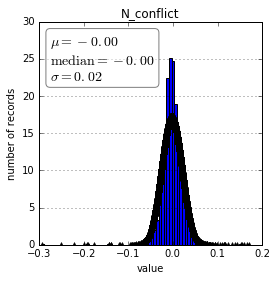

In [5]:
interact(plot_dist, col_name=full_list);    

All sentiments and the price direction itself follow a normal distribution. Most of them are centered at zero or close to zero.

In [6]:
def dist_probs(col_name, value, showboth=True, suppress_print=False):
    unholed = data[col_name].dropna().sort_values(inplace=False)
    mean = np.mean(unholed)
    mod = sc.stats.norm(mean, np.std(unholed))
    inner = mod.cdf(value) - mod.cdf(-value)
    
    if (not suppress_print):
        print(col_name, '(mean: {:.3f}'.format(mean) +')')
        print('probability range from {:.3f} to {:.3f}'.format((mean+value),(mean-value)))
        print('inner probability: {:.3f}'.format(inner))
        print('outer probability: {:.3f}'.format(1-inner))
    if (not suppress_print and showboth):
        print('probability less than {:.3f}'.format(-value), ':', mod.cdf(-value))
        print('probability greater than {:.3f}'.format(value), ':', 1-mod.cdf(value))
    return inner
# stat, pvalue = sc.stats.normaltest(unholed, nan_policy='omit')
# print('\ntest stat:', stat)
# print('pvalue:', pvalue)
# print('small pvalue => normal distribution')

In [7]:
interact(dist_probs, col_name=full_list, value=(0.01, .1, .001), showboth=False, suppress_print=False);

N_conflict (mean: -0.003)
probability range from 0.052 to -0.058
inner probability: 0.982
outer probability: 0.018


0.9824184476034582

In [8]:
tenth_inner_prob = {} #probability value will land within .1 of the mean
for sent in sent_list:
    tenth_inner_prob[sent] = dist_probs(sent, .1, suppress_print=True)

import operator
sorted_tenth_prob = sorted(tenth_inner_prob.items(), key=operator.itemgetter(1))
less_than_85_percent = list(filter(lambda x: x[1] < .85, sorted_tenth_prob))
greater_than_85_percent = list(filter(lambda x: x[1] >= .85, sorted_tenth_prob))
print(less_than_85_percent)

[('S_emotionVsFact', 0.034389480252333758), ('N_relativeBuzz', 0.053557532575018822), ('N_emotionVsFact', 0.082084656476514264), ('S_sentiment', 0.22952024652544956), ('N_sentiment', 0.23856385865161123), ('S_relativeBuzz', 0.29934240113785343)]


Only six of the fifty sentiments have more than 15% of their probability beyond $\pm .1$ of their mean.
Most sentiments have virtually all of their values (over 99%) within .1 of the mean. The above makes sense for relative buzz because it is based on the absolute buzz - which is essentially the magnitude of the psychvars. It should have the highest variance:

In [9]:
less_85_stats = pd.DataFrame(columns=['sent', 'mean', 'variance'])
lt85 = [tup[0] for tup in less_than_85_percent]
for sent in lt85:
    less_85_stats = less_85_stats.append({'sent':sent, 'mean':data[sent].mean(), 'variance':data[sent].var()}, ignore_index=True)

greater_85_stats = pd.DataFrame(columns=['sent', 'mean', 'variance'])
gt85 = [tup[0] for tup in greater_than_85_percent]
for sent in gt85:
    greater_85_stats = greater_85_stats.append({'sent':sent, 'mean':data[sent].mean(), 'variance':data[sent].var()}, ignore_index=True)

less_85_stats

,sent,mean,variance
0,S_emotionVsFact,0.150969,0.000785
1,N_relativeBuzz,0.304652,0.016274
2,N_emotionVsFact,0.140022,0.000828
3,S_sentiment,-0.166715,0.008240
4,N_sentiment,-0.178377,0.012997
5,S_relativeBuzz,0.151602,0.010358


In [10]:
def corr_matrix(data, features, labels):
    corr = pd.DataFrame()
    for feat in features:
        row = {}
        row['feature'] = feat
        row.update({label: data[feat].corr(data[label]) for label in labels})
        corr = corr.append(row, ignore_index=True)
    return corr

In [11]:
corr_lt85 = corr_matrix(data, lt85, label_list)
corr_lt85

,Z_dailydir,Z_dailydir2,feature
0,-0.005355,-0.005436,S_emotionVsFact
1,-0.050142,-0.057469,N_relativeBuzz
2,-0.031334,-0.036475,N_emotionVsFact
3,0.027942,0.032776,S_sentiment
4,0.021676,0.018100,N_sentiment
5,-0.030528,-0.036869,S_relativeBuzz


The daily price change of oil 'Z_dailypct' is normally distributed with a mean of 0.0 and a standard deviation of 2.25%:

9.062530468585286e-05
0.022500369064066824


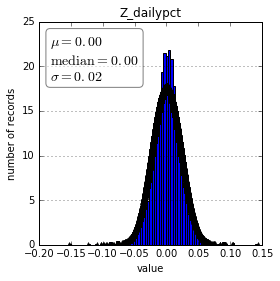

In [12]:
plot_dist('Z_dailypct')
print(data['Z_dailypct'].mean())
print(data['Z_dailypct'].std())

In [13]:
dist_probs('Z_dailypct', .015, showboth=True, suppress_print=False); #binning threshold candidate
print()
dist_probs('Z_dailypct', .022, showboth=True, suppress_print=False);
print()
dist_probs('Z_dailypct', .044, showboth=True, suppress_print=False);
print()
dist_probs('Z_dailypct', .066, showboth=True, suppress_print=False);
#dist_probs('Z_dailypct', .0225, showboth=True, suppress_print=False);

Z_dailypct (mean: 0.000)
probability range from 0.015 to -0.015
inner probability: 0.495
outer probability: 0.505
probability less than -0.015 : 0.251184481597
probability greater than 0.015 : 0.253757972183

Z_dailypct (mean: 0.000)
probability range from 0.022 to -0.022
inner probability: 0.672
outer probability: 0.328
probability less than -0.022 : 0.163071655051
probability greater than 0.022 : 0.165064188157

Z_dailypct (mean: 0.000)
probability range from 0.044 to -0.044
inner probability: 0.950
outer probability: 0.050
probability less than -0.044 : 0.0250098580792
probability greater than 0.044 : 0.0254846066834

Z_dailypct (mean: 0.000)
probability range from 0.066 to -0.066
inner probability: 0.997
outer probability: 0.003
probability less than -0.066 : 0.00165339662742
probability greater than 0.066 : 0.00169687039514


At least one new label column will be made with a threshold level of $\pm 1.5$% with four labels. This label scheme was chosen because it balances row assignment frequency (25%) to all labels:
- up_large   (Z_dailypct >= .015)
- down_large (Z_dailypct <= -.015))
- up_small   (0 < Z_dailypct < .015)
- down_small (0 > Z_dailypct > -.015))

In [14]:
def plot_feature(feature=None, label=None,
                remove_zeros=True,                                           #pre-processing options
                atomic_transform=lambda x:x, delta_transform=lambda x:x, combo='delta_atomic', #processing options
                low_clip=-1.0, high_clip=1.0,
                show_class='all'):                                                             #post-processing options

    assert(feature and label)
    output = pd.DataFrame({feature: data[feature], label: data[label], 'year': data['year']})
    output.dropna(axis=0, subset=[label], inplace=True) #Drop rows with no label
    output.dropna(axis=0, subset=[feature], inplace=True)
    output[label] = output[label].astype(int)
    
    if (remove_zeros):
        output = output[output[feature] != 0]

    #TODO - upper and lower bound filtering (throw out middle)
        #past_period - number of rows behind the "big moves" to keep in
        #Need this for delta transforms

    if (combo == 'atomic'):
        output[combo] = atomic_transform(output[feature])
    elif (combo == 'delta'):
        output[combo] = delta_transform(output[feature])
    elif (combo == 'atomic_delta'):
        output[combo] = atomic_transform(delta_transform(output[feature]))
    elif (combo == 'delta_atomic'):
        output[combo] = delta_transform(atomic_transform(output[feature]))
    else:
        output[combo] = output[feature]

    low_clip = low_clip if low_clip > output[combo].min() else output[combo].min()
    high_clip = high_clip if high_clip < output[combo].max() else output[combo].max()
    output[combo] = np.clip(output[combo], low_clip, high_clip)

    #Post processing
    if (show_class != 'all'):
        if (show_class == 'up'):
            output = output[output[label] > 1]
        elif (show_class == 'down'):
            output = output[output[label] < -1]
        elif (show_class == 'sideways'):
            output = output[output[label] == 0]
    
    #TODO - add year specific removal option

    data_space = np.linspace(0, len(output[combo])-1, num=len(output[combo]))
    plt.figure(figsize=(25,10))
    #plt.figure().tight_layout()
    plt.title('Data Segmentation Graph')
    plt.xlabel('Observation')
    plt.ylabel('Feature Value')
    plt.xlim([data_space.min()-100, data_space.max() + 100])
    plt.grid(b=True, which='major', axis='y')
    #textstr = '$\mu=%.2f$\n$\mathrm{median}=%.2f$\n$\sigma=%.2f$'%(mean, median, sdev)

    norm = mpl.colors.Normalize(vmin=output[label].min(), vmax=output[label].max()) 
    plt.scatter(data_space, output[combo], c=norm(output[label]), cmap=plt.cm.jet_r)
    plt.colorbar()
    plt.show()

    sent_means = []
    sent_vars = []
    combo_means = []
    combo_vars = []
    class_values = sorted(output[label].unique())
    for class_value in class_values:
        sent_means.append(output.loc[output[label] == class_value, feature].mean())
        combo_means.append(output.loc[output[label] == class_value, combo].mean())
        sent_vars.append(output.loc[output[label] == class_value, feature].var())
        combo_vars.append(output.loc[output[label] == class_value, combo].var())
    fig = plt.figure()
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle('stats segmented by class label')
    ax[0].set_title('mean')
    ax[0].set_ylabel('feature value')
    ax[0].plot(class_values, sent_means, 'ok', label='sent_means')
    ax[0].plot(class_values, combo_means, 'r^', label='combo_means')
    ax[0].legend()
    
    ax[1].set_title('variance')
    ax[1].set_xlabel('label value')
    ax[1].plot(class_values, sent_vars, 'ok', label='sent_vars')
    ax[1].plot(class_values, combo_vars, 'r^', label='combo_vars')
    ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    return

#config options
atomic_fn_options = OrderedDict({'nothing': lambda x:x, 'round': lambda a: np.around(a, 2), 'log10':np.log10, 'sine':np.sin, 'sinh':np.sinh})
delta_fn_options = OrderedDict({'nothing': lambda x:x, 'log10':np.log10, 'sine':np.sin, 'sinh':np.sinh})
feature_list = tuple(sorted([col for col in data.columns if ((col[0]=='N' or col[0]=='S') and 'buzz' not in col)]))

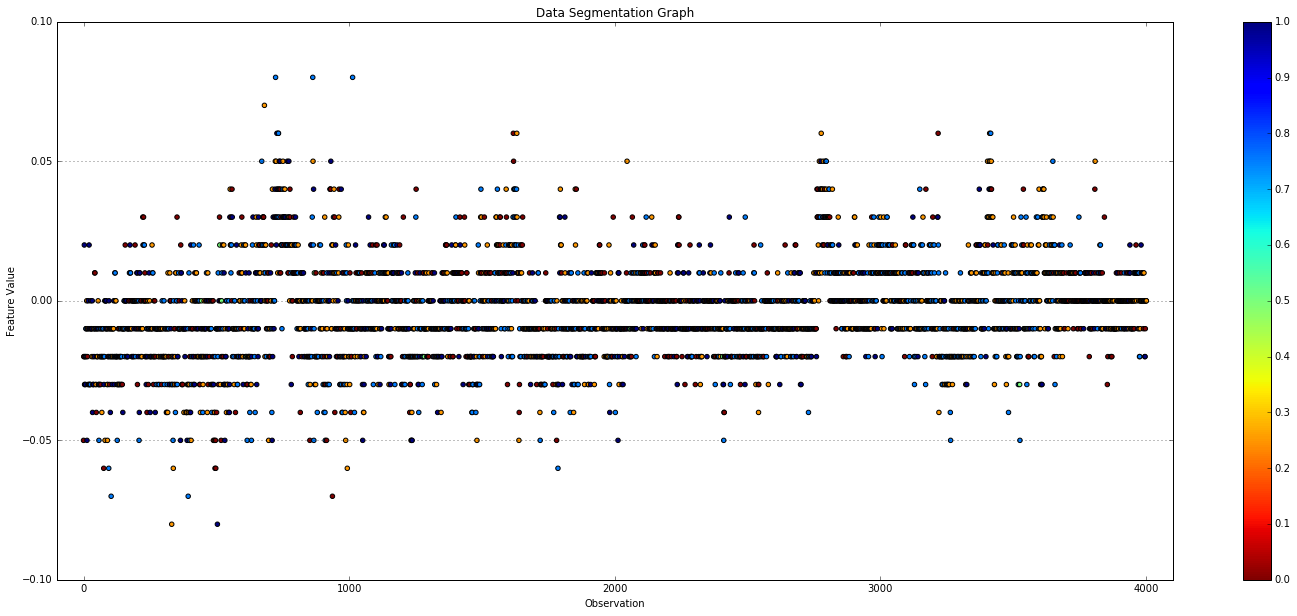

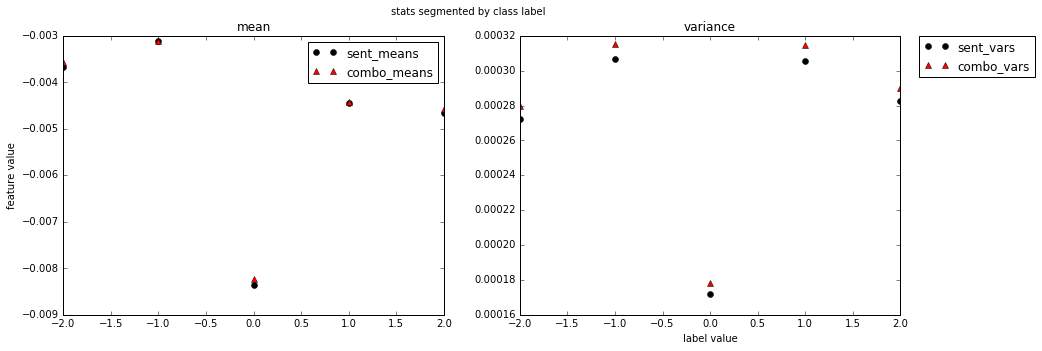

In [15]:
interact(plot_feature,
                feature=feature_list,
                label=tuple(label_list),
                remove_zeros=OrderedDict({'remove': True, 'keep': False}),
                atomic_transform=atomic_fn_options,
                delta_transform=delta_fn_options,
                combo=('none','atomic','delta','atomic_delta','delta_atomic'),
                low_clip=(-1.0, 0.0, .001),
                high_clip=(.0, 1.0, .001),
                show_class=('all', 'up', 'down', 'sideways'));

In [16]:
#Show sentiment characteristics at sizable (at least greater than 1%) moves
move_thresh = .06
large_moves_pos = data[data.Z_dailypct >= move_thresh]
large_moves_neg = data[data.Z_dailypct <= -move_thresh]
print('all rows:', len(data))
print('all rows, no weekends:', len(data.dropna(axis=0, subset=['Z_dailydir'])))

print('\ntotal large moves:', len(large_moves_pos) + len(large_moves_neg))
print('large up moves [greater than', str(move_thresh) +']:', len(large_moves_pos))
print('large down moves [less than', str(-move_thresh) +']:', len(large_moves_neg))

all rows: 5844
all rows, no weekends: 4014

total large moves: 76
large up moves [greater than 0.06]: 38
large down moves [less than -0.06]: 38


TODO: Compare sentiment vectors at large movement thresholds ($\pm 6$% , $\pm 4$% , $\pm 2$% , $\pm 1.5$%) to sentiment vectors of the other price movements.
Compare things such as min/max, mean, median, variance, average probability (based on normal dist)

In [17]:
#write plot_split_hists function
#plots histograms of the feature segmented by the label
def infoPurityGraphs(filedir, files):
    numBins = 500
    for datasource in files:
        df = tn.load_csv(Process.g_tsetdir +filedir, datasource +'.csv')
        df.drop('Unnamed: 0', axis=1, inplace=True)     #Get rid of id col
        df.drop('date', axis=1, inplace=True)           #Get rid of date col
        pdf = PdfPages(Process.g_reportdir + 'purityhists/' +filedir +datasource +'.pdf')

        #Split into up, down, and sideways groups
        ups = df.loc[df['label'] == 1]
        downs = df.loc[df['label'] == -1]
        sideways = df.loc[df['label'] == 0]        

        for column in df:
            if (column != 'label'):
                pyplot.title(column)
                pyplot.hist(ups[column].values, bins=numBins, alpha=0.3, label='up')
                pyplot.hist(downs[column].values, bins=numBins, alpha=0.3, label='down')
                pyplot.hist(sideways[column].values, bins=numBins, alpha=0.3, label='sideways')
                pyplot.legend(loc='upper right')
                pdf.savefig()
                pyplot.cla()
        pdf.close()